# PROBLEM STATEMENT#

The data scientists at BigMart have collected 2013 sales data for 1559 products across 10 stores in different cities. Also, certain attributes of each product and store have been defined. The aim is to build a predictive model and predict the sales of each product at a particular outlet.

Using this model, BigMart will try to understand the properties of products and outlets which play a key role in increasing sales.

Please note that the data may have missing values as some stores might not report all the data due to technical glitches. Hence, it will be required to treat them accordingly.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display_html

from scipy import stats

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder


from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score


from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae

from xgboost import XGBRegressor


import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv(r"C:\Users\Sasidharan\Desktop\Data Science Projects\Big Mart Sales Prediction\big_mart_sales.csv")

**DATA EXPLORATION**

In [3]:
data.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [4]:
print("Size of dataset :",data.shape)

Size of dataset : (8523, 12)


In [5]:
data.describe()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,7060.000000,8523.000000,8523.000000,8523.000000,8523.000000
mean,12.857645,0.066132,140.992782,1997.831867,2181.288914
std,4.643456,0.051598,62.275067,8.371760,1706.499616
min,4.555000,0.000000,31.290000,1985.000000,33.290000
25%,8.773750,0.026989,93.826500,1987.000000,834.247400
50%,12.600000,0.053931,143.012800,1999.000000,1794.331000
75%,16.850000,0.094585,185.643700,2004.000000,3101.296400
max,21.350000,0.328391,266.888400,2009.000000,13086.964800


In [6]:
# % of Missing Data
(data.isnull().sum() / data.shape[0]).sort_values(ascending = False)

Outlet_Size                  0.282764
Item_Weight                  0.171653
Item_Outlet_Sales            0.000000
Outlet_Type                  0.000000
Outlet_Location_Type         0.000000
Outlet_Establishment_Year    0.000000
Outlet_Identifier            0.000000
Item_MRP                     0.000000
Item_Type                    0.000000
Item_Visibility              0.000000
Item_Fat_Content             0.000000
Item_Identifier              0.000000
dtype: float64

In [7]:
data.corr()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
Item_Weight,1.000000,-0.014048,0.027141,-0.011588,0.014123
Item_Visibility,-0.014048,1.000000,-0.001315,-0.074834,-0.128625
Item_MRP,0.027141,-0.001315,1.000000,0.005020,0.567574
Outlet_Establishment_Year,-0.011588,-0.074834,0.005020,1.000000,-0.049135
Item_Outlet_Sales,0.014123,-0.128625,0.567574,-0.049135,1.000000


In [8]:
data.dtypes

Item_Identifier               object
Item_Weight                  float64
Item_Fat_Content              object
Item_Visibility              float64
Item_Type                     object
Item_MRP                     float64
Outlet_Identifier             object
Outlet_Establishment_Year      int64
Outlet_Size                   object
Outlet_Location_Type          object
Outlet_Type                   object
Item_Outlet_Sales            float64
dtype: object

In [9]:
categorical = data.columns[data.dtypes == 'object']
numerical = data.columns[data.dtypes != 'object']

In [10]:
data[categorical].nunique()

Item_Identifier         1559
Item_Fat_Content           5
Item_Type                 16
Outlet_Identifier         10
Outlet_Size                3
Outlet_Location_Type       3
Outlet_Type                4
dtype: int64

In [11]:
for category in categorical:
    print(data[category].unique(),'\n')

['FDA15' 'DRC01' 'FDN15' ... 'NCF55' 'NCW30' 'NCW05'] 

['Low Fat' 'Regular' 'low fat' 'LF' 'reg'] 

['Dairy' 'Soft Drinks' 'Meat' 'Fruits and Vegetables' 'Household'
 'Baking Goods' 'Snack Foods' 'Frozen Foods' 'Breakfast'
 'Health and Hygiene' 'Hard Drinks' 'Canned' 'Breads' 'Starchy Foods'
 'Others' 'Seafood'] 

['OUT049' 'OUT018' 'OUT010' 'OUT013' 'OUT027' 'OUT045' 'OUT017' 'OUT046'
 'OUT035' 'OUT019'] 

['Medium' nan 'High' 'Small'] 

['Tier 1' 'Tier 3' 'Tier 2'] 

['Supermarket Type1' 'Supermarket Type2' 'Grocery Store'
 'Supermarket Type3'] 



In [12]:
# Fixing repetition of categories in Item Fat Content;

data["Item_Fat_Content"] = data["Item_Fat_Content"].map({'Low Fat' : 'LF' , 'low fat' : 'LF','LF' : 'LF',
     'Regular' : 'R', 'reg' : 'R'})

In [13]:
data["Item_Fat_Content"].value_counts()

LF    5517
R     3006
Name: Item_Fat_Content, dtype: int64

**DATA VISUALIZATION**

In [14]:
data.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,LF,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,R,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,LF,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,R,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,LF,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


**Investigating certain relationships between variables using data visualization.Additionaly we will also be able to identify if outliers exist in the numerical variables.**

1. Outlet atttributes (size, location, type) vs sales
2. Outlet attributes vs product visibility
3. Visibilty vs sales
4. Item MRP vs sales
5. Fat content vs sales

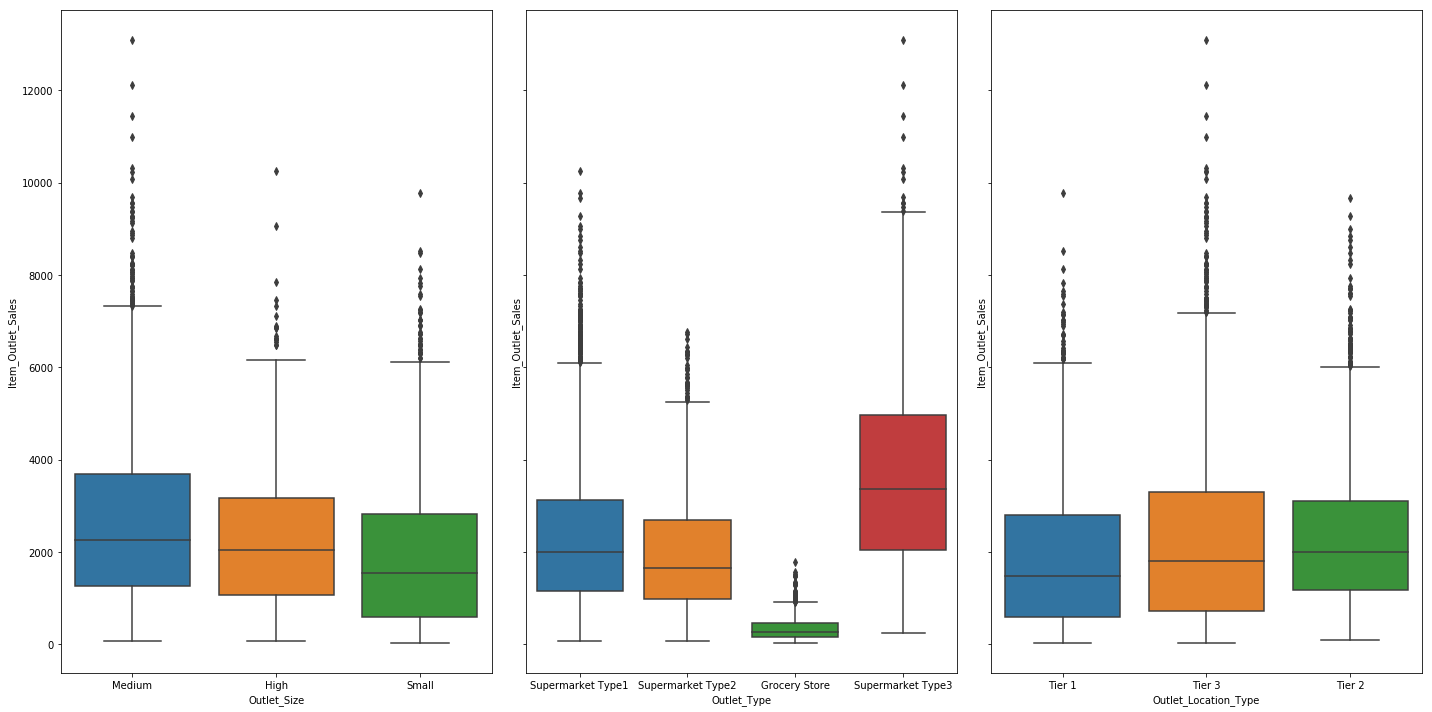

In [15]:
%matplotlib inline

fig,ax = plt.subplots(1,3, figsize = (20,10), sharey = True)

sns.boxplot(ax = ax[0], x = "Outlet_Size", y = "Item_Outlet_Sales", data=data)
sns.boxplot(ax = ax[1], x = "Outlet_Type", y = "Item_Outlet_Sales", data=data)
sns.boxplot(ax = ax[2], x = "Outlet_Location_Type", y = "Item_Outlet_Sales", data=data)

plt.tight_layout()

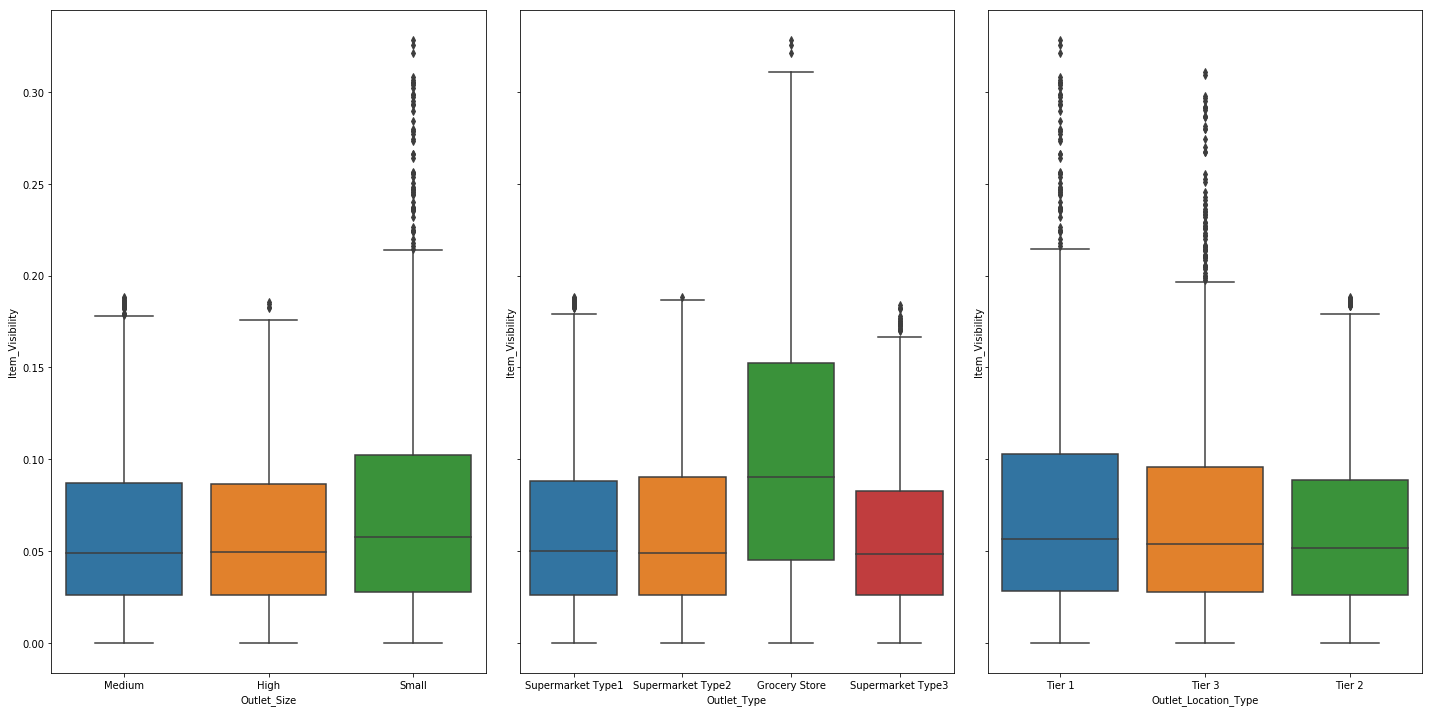

In [16]:
fig,ax = plt.subplots(1,3, figsize = (20,10), sharey = True)

sns.boxplot(ax = ax[0], x = "Outlet_Size", y = "Item_Visibility", data=data)
sns.boxplot(ax = ax[1], x = "Outlet_Type", y = "Item_Visibility", data=data)
sns.boxplot(ax = ax[2], x = "Outlet_Location_Type", y = "Item_Visibility", data=data)

plt.tight_layout()

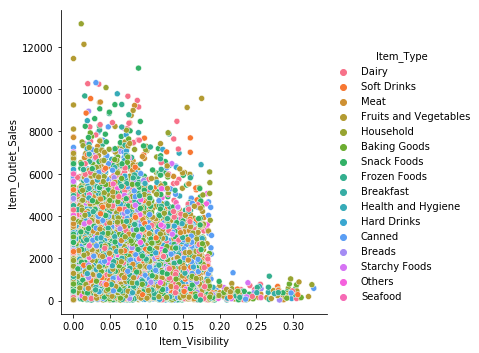

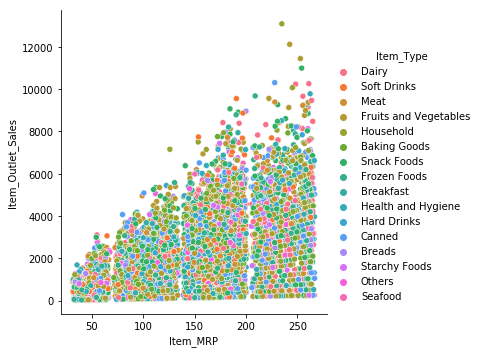

In [17]:
sns.relplot(x='Item_Visibility' , y = 'Item_Outlet_Sales', data = data, hue = 'Item_Type')
sns.relplot(x='Item_MRP' , y = 'Item_Outlet_Sales', data = data, hue = 'Item_Type')
plt.show()

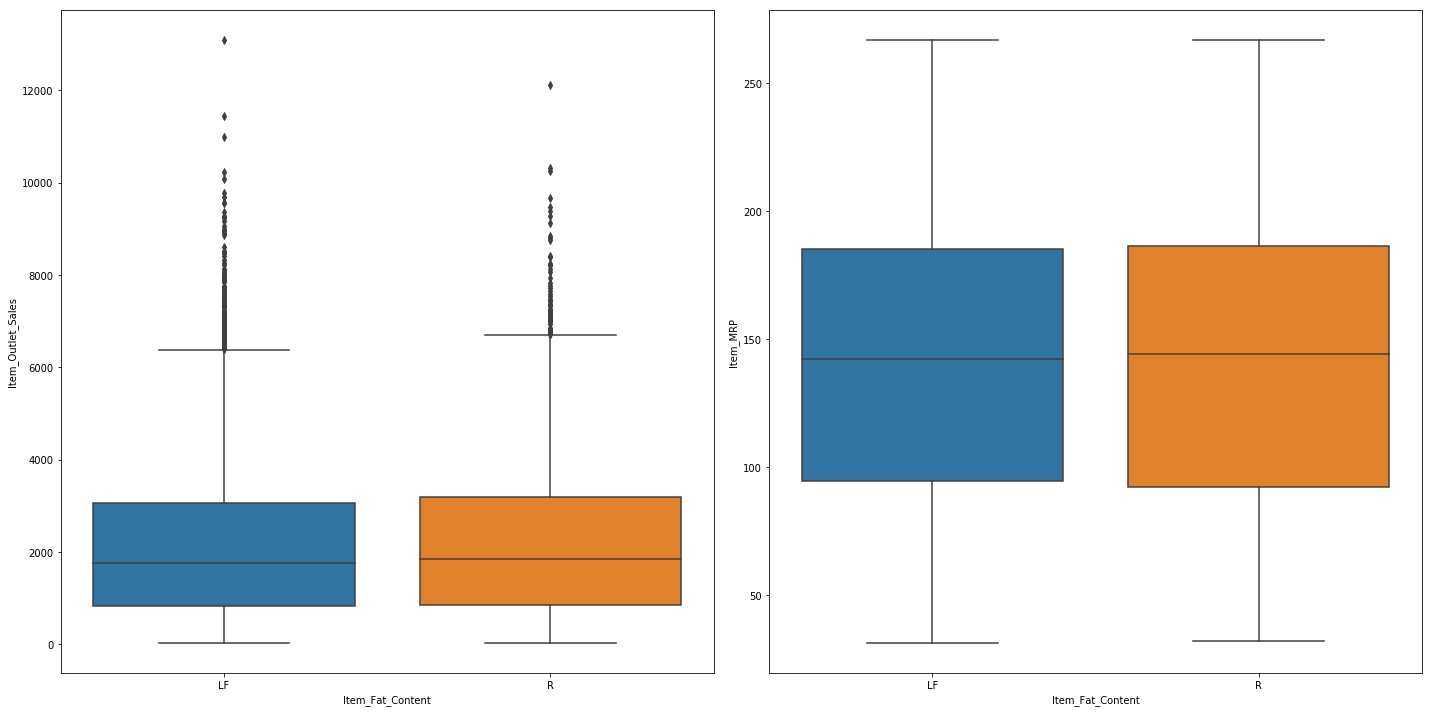

In [18]:
fig,ax = plt.subplots(1,2, figsize = (20,10), sharey = False)

sns.boxplot(ax = ax[0], x = "Item_Fat_Content", y = "Item_Outlet_Sales", data=data)
sns.boxplot(ax = ax[1], x = "Item_Fat_Content", y = "Item_MRP", data=data)

plt.tight_layout()

** DIVIDING DATA INTO TRAIN AND TEST DATA SET**

In [19]:
y = data["Item_Outlet_Sales"]
x = data.drop(["Item_Outlet_Sales"], axis = 1)

x_train, x_test, y_train, y_test = train_test_split(x,y, train_size = 0.7, random_state=42)

**MISSING VALUE TREATMENT( Outlet Size & Item Weight)**

**1. Outlet Size**

In [20]:
# Each unique outlet has only only size value associated with them; 

x_train.loc[x_train["Outlet_Size"].isna()]["Outlet_Identifier"].value_counts()

OUT017    652
OUT045    649
OUT010    389
Name: Outlet_Identifier, dtype: int64

In [21]:
x_train.loc[x_train["Outlet_Identifier"] == 'OUT010'][["Outlet_Location_Type","Outlet_Type"]].head(1)

,Outlet_Location_Type,Outlet_Type
1921,Tier 3,Grocery Store


In [22]:
x_train.loc[x_train["Outlet_Identifier"] == 'OUT017'][["Outlet_Location_Type","Outlet_Type"]].head(1)

,Outlet_Location_Type,Outlet_Type
558,Tier 2,Supermarket Type1


In [23]:
x_train.loc[x_train["Outlet_Identifier"] == 'OUT045'][["Outlet_Location_Type","Outlet_Type"]].head(1)

,Outlet_Location_Type,Outlet_Type
2537,Tier 2,Supermarket Type1


In [24]:
x_train.loc[(x_train["Outlet_Location_Type"] == "Tier 2") & (data["Outlet_Type"] == "Supermarket Type1") ]["Outlet_Size"].value_counts()

Small    656
Name: Outlet_Size, dtype: int64

In [25]:
x_train.loc[(x_train["Outlet_Location_Type"] == "Tier 3") & (data["Outlet_Type"] == "Grocery Store") ]["Outlet_Size"].value_counts()

Series([], Name: Outlet_Size, dtype: int64)

In [26]:
x_train.loc[x_train["Outlet_Type"] == "Grocery Store"]["Outlet_Size"].value_counts()

Small    355
Name: Outlet_Size, dtype: int64

In [27]:
# Outlets similar to these outlets with missing values have small as size,so we will fill it in; 

x_train["Outlet_Size"] = x_train["Outlet_Size"].fillna('Small')
x_test["Outlet_Size"] = x_test["Outlet_Size"].fillna('Small')

**2. Item Weight**

In [28]:
x_train.loc[x_train["Item_Weight"].isna()]["Item_Type"].value_counts()

Fruits and Vegetables    157
Snack Foods              155
Household                110
Frozen Foods              97
Dairy                     83
Baking Goods              76
Canned                    70
Health and Hygiene        63
Meat                      55
Soft Drinks               51
Breads                    27
Hard Drinks               23
Others                    22
Breakfast                 15
Starchy Foods             14
Seafood                    5
Name: Item_Type, dtype: int64

In [29]:
mean_weights = x_train.groupby("Item_Type")["Item_Weight"].mean()

In [30]:
mean_weights

Item_Type
Baking Goods             12.625483
Breads                   11.482348
Breakfast                13.042000
Canned                   12.432684
Dairy                    13.544335
Frozen Foods             12.764190
Fruits and Vegetables    13.157206
Hard Drinks              11.675971
Health and Hygiene       13.147003
Household                13.509312
Meat                     13.264682
Others                   13.946912
Seafood                  12.157059
Snack Foods              12.992963
Soft Drinks              11.809961
Starchy Foods            13.695098
Name: Item_Weight, dtype: float64

In [31]:
for item in mean_weights.index:
    x_train["Item_Weight"][(x_train["Item_Weight"].isna()) & (x_train["Item_Type"] == item)] = mean_weights[item]
    x_test["Item_Weight"][(x_test["Item_Weight"].isna()) & (x_test["Item_Type"] == item)] = mean_weights[item]

** OUTLIER TREATMENT and FEATURE ENGINEERING**

In [32]:
x_train.skew()

Item_Weight                  0.076743
Item_Visibility              1.165437
Item_MRP                     0.117399
Outlet_Establishment_Year   -0.399953
dtype: float64

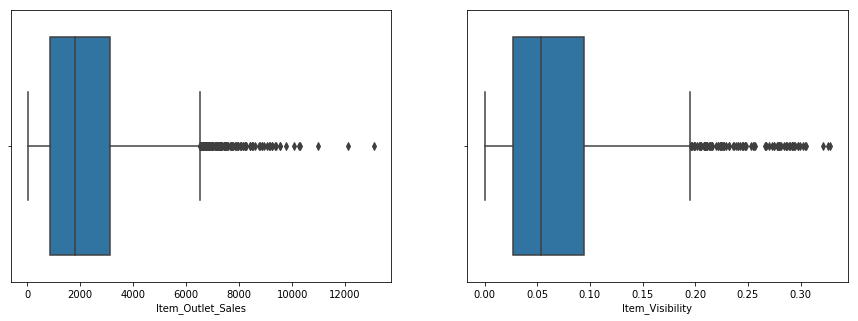

In [33]:
fig,ax = plt.subplots(1,2, figsize=(15,5))
sns.boxplot(y_train, ax = ax[0])
sns.boxplot(x_train["Item_Visibility"], ax = ax[1])
plt.show()

In [34]:
# Capping the outliers using 75th Percentile

# 1.Item Visibility
vis_q1 = x_train["Item_Visibility"].quantile(0.25) 
vis_q3 = x_train["Item_Visibility"].quantile(0.75)
vis_upper =  vis_q3 + 1.5*(vis_q3 - vis_q1)
x_train.loc[x_train.Item_Visibility > vis_upper , 'Item_Visibility'] = vis_q3
x_test.loc[x_test.Item_Visibility > vis_upper , 'Item_Visibility'] = vis_q3

# 2.Item Outlet Sales
sales_q1 = y_train.quantile(0.25) 
sales_q3 = y_train.quantile(0.75)
sales_upper =  sales_q3 + 1.5*(sales_q3 - sales_q1)


m = pd.DataFrame(y_train)
m.loc[m.Item_Outlet_Sales > sales_upper , 'Item_Outlet_Sales'] = sales_q3
y_train = m["Item_Outlet_Sales"]

#n = pd.DataFrame(y_test)
#n.loc[n.Item_Outlet_Sales > sales_upper , 'Item_Outlet_Sales'] = sales_q3
#y_test = n["Item_Outlet_Sales"]

In [35]:
# Feature Creation (using variable that had good correlation with sales : Item MRP and Item Visibility)


# 1. Mean Outlet Visibility
mean_vis = x_train.groupby(["Outlet_Identifier"])["Item_Visibility"].mean()
x_train["Mean_Visibility_outlet"] = x_train["Outlet_Identifier"].apply(lambda x: mean_vis[x])
x_test["Mean_Visibility_outlet"] = x_test["Outlet_Identifier"].apply(lambda x: mean_vis[x])    

# 2. Creating subcategories using Item Identifiers;
x_train["Item_Identifier"] = x_train["Item_Identifier"].transform(lambda x : x[0:3])
x_test["Item_Identifier"] = x_test["Item_Identifier"].transform(lambda x : x[0:3])

#3. Difference from mean outlet visibility
x_train["Visibility_diff"] = x_train["Item_Visibility"] - x_train["Mean_Visibility_outlet"]
x_test["Visibility_diff"] = x_test["Item_Visibility"] - x_test["Mean_Visibility_outlet"]

# 4. Average Store MRP
mean_mrp = x_train.groupby(["Outlet_Identifier"])["Item_MRP"].mean()
x_train["Mean_MRP"] = x_train["Outlet_Identifier"].apply(lambda x: mean_mrp[x])
x_test["Mean_MRP"] = x_test["Outlet_Identifier"].apply(lambda x: mean_mrp[x])  

# 5. Mean Visibilty at outlet level and individual item type
mean_vis_by_item = x_train.groupby(["Outlet_Identifier","Item_Type"])["Item_Visibility"].mean()

def item(A,B):
    return mean_vis_by_item[A,B]

x_train["Mean_Vis"] = x_train[["Outlet_Identifier","Item_Type"]].apply(lambda x:item(x["Outlet_Identifier"],x["Item_Type"]),axis=1)
x_test["Mean_Vis"] = x_test[["Outlet_Identifier","Item_Type"]].apply(lambda x:item(x["Outlet_Identifier"],x["Item_Type"]),axis=1)

# 6. Diff from mean outlet type visibility
x_train["Visibility_diff_type"] = x_train["Item_Visibility"] - x_train["Mean_Vis"]
x_test["Visibility_diff_type"] = x_test["Item_Visibility"] - x_test["Mean_Vis"]


In [36]:
# Encoding Categorical Features
categorical_features = x_train.columns[x_train.dtypes == 'object']
oh = OneHotEncoder(dtype = 'int64', handle_unknown = 'ignore')
oh.fit(x_train[categorical_features])

OneHotEncoder(dtype='int64', handle_unknown='ignore')

In [37]:
xtrain_enc = pd.DataFrame(oh.transform(x_train[categorical_features]).toarray())
xtest_enc = pd.DataFrame(oh.transform(x_test[categorical_features]).toarray())

x_train.drop(x_train[categorical_features],axis=1,inplace=True)
x_test.drop(x_test[categorical_features],axis=1,inplace=True)

xtrain_final = x_train.join(xtrain_enc)
xtest_final = x_test.join(xtest_enc)

**BASELINE MODEL**

In [38]:
# Creating a mean baseline model for future error evaluation

baseline_data = pd.read_csv(r"C:\Users\Sasidharan\Desktop\Data Science Projects\Big Mart Sales Prediction\big_mart_sales.csv")

from sklearn.utils import shuffle

baseline_data = shuffle(baseline_data, random_state=42)
div = int(baseline_data.shape[0]/4)
train = baseline_data.loc[:3*div+1,:]
test = baseline_data.loc[3*div+1:]

test["Mean_Sales"] = train["Item_Outlet_Sales"].mean()
print("Baseline Mean Model error is:",mae(test["Item_Outlet_Sales"],test["Mean_Sales"]),"\n")

Baseline Mean Model error is: 1355.4481105570344 



**MODEL and PARAMETER OPTIMIZATION**

In [39]:
from sklearn.model_selection import RandomizedSearchCV

optimization_data = xtrain_final.copy()

x = optimization_data
y = y_train

XGB = XGBRegressor()

In [40]:
# Parameters for tuning the model;

n_estimators = [100 , 500 , 1000, 1500 , 2000]
max_depth = [2, 3, 5, 10]
learning_rate = [0.05, 0.1, 0.15, 0.2]
min_child_weight = [1, 2, 3, 4]


hyperparameter = {'n_estimators' : n_estimators,
                 'max_depth' : max_depth,
                 'learning_rate' : learning_rate,
                 'min_child_weight' : min_child_weight}

In [41]:
random_cv = RandomizedSearchCV(estimator = XGB, param_distributions = hyperparameter, cv = 5,
                              n_iter = 5, scoring = 'neg_mean_absolute_error', n_jobs = 4,
                              verbose = 5, return_train_score = True, random_state = 42)

In [42]:
random_cv.fit(x,y)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          enable_categorical=False, gamma=None,
                                          gpu_id=None, importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=None,
                                          max_delta_step=None, max_depth=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=...
                                          reg_alpha=None, reg_lambda=None,
                                          scale_pos_weight=None, subsample=None,
                                   

In [43]:
random_cv.best_params_

{'n_estimators': 100,
 'min_child_weight': 2,
 'max_depth': 3,
 'learning_rate': 0.05}

In [44]:
model =  XGBRegressor(n_estimators = 100, min_child_weight = 2, max_depth = 3, learning_rate = 0.05)
model.fit(xtrain_final,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.05, max_delta_step=0,
             max_depth=3, min_child_weight=2, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [45]:
print("Final Model error (MAE) on seen data :", -1*random_cv.best_score_,'\n')

Final Model error (MAE) on seen data : 715.621721783672 



In [46]:
print("Final Model error (MAE) on unseen data :", mae(model.predict(xtest_final),y_test))

Final Model error (MAE) on unseen data : 745.6629390294021


*****